## 期中考

In [32]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,GradientBoostingRegressor, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC, LinearSVC
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector

from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus

import warnings
warnings.filterwarnings(action='ignore')

## Define the common functions

In [2]:
def report_overview(df):
    #df.describe()
    overview = df.describe().T.reset_index()
    overview = overview.rename(columns={"index":"column"})

    # na percentage
    na_percentage= df.apply(lambda c: (c.isna().sum()/len(c))*100)
    na_percentage = na_percentage.reset_index()
    na_percentage.columns=["column", "na%"]
    overview = pd.merge(overview, na_percentage, on='column')
    # dtype
    dtype = df.dtypes.reset_index()
    dtype.columns=['column', 'dtype']
    overview = pd.merge(overview, dtype, on='column')
    # 3 samples
    sample= df.sample(n=3,  random_state=1).T.reset_index()
    sample = sample.rename(columns={"index":"column"})
    overview = pd.merge(overview, sample, on='column')
    return overview

In [3]:
# draw the heatmap
def draw_heatmap(data, figsize):
    corr = data.corr()
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', ax=ax)
    plt.show()

In [4]:
def select_features(data, target, models):
    train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.25, random_state=1234)
    for model in models:
        selected_f = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')
        selected_f.fit(train_X, train_y)
        
        print("** Using {} **".format(model.__class__.__name__))
        print("The number of selected features with cross-validation: {}".format(selected_f.n_features_))
        print("The mask of selected features: {}".format(selected_f.support_))
        print("The selected features:{}".format(data.columns[selected_f.support_]))
        print("The feature ranking: {}".format(selected_f.ranking_))
    
        #select_train = mm_train.iloc[:, select_f]

In [5]:
def search_params(data, target, model, param_grid):
    train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.25, random_state=1234)
    model_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=1, cv=5, verbose=1)
    model_search.fit(train_X, train_y)            
    predict_y = model_search.predict(test_X)
        
    print("** Using {} **".format(model.__class__.__name__))
    print("Best Accuracy: {} using {}".format(model_search.best_score_, model_search.best_params_))

In [6]:
def cross_evalaute(data, target, modelset):
    train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.25, random_state=1234)
    for model in modelset:
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)

        acc = accuracy_score(test_y, pred_y)
        print("Best Accuracy: {} using {}".format(acc, model.__class__.__name__))

In [93]:
def to_datetime(x):
    if pd.isna(x):
        return None
    else:
        return pd.to_datetime(x, format='%Y%m%d', errors='ignore')

def to_dayofweek(x):
    if pd.isna(x):
        return None
    else:
        return int(x.dayofweek+1)   

def to_isweekend(x):
    if pd.isna(x):
        return None
    elif int(x.dayofweek+1)>=6:
        return 1
    else:
        return 0

def to_discount_type(x):
    if ":" in x:
        return 1
    else:
        return 0

def to_discount_ratio(x):
    if ":" in x:
        return 1- (float(x.split(":")[1])/float(x.split(":")[0]))
    else:
        return x    

def to_discount_x(x):
    if ":" in x:
        return int(x.split(":")[0])
    else:
        return 0
        
def to_discount_y(x):
    if ":" in x:
        return int(x.split(":")[1])
    else:
        return 0

## Read train data

In [8]:
# read dataset
DATA_ROOT = os.path.join(os.getcwd(), "data")
train_offline =  pd.read_csv(os.path.join(DATA_ROOT, "train_offline.csv"))

In [9]:
train_offline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160742 entries, 0 to 1160741
Data columns (total 7 columns):
User_id          1160742 non-null int64
Merchant_id      1160742 non-null int64
Coupon_id        746969 non-null float64
Discount_rate    746969 non-null object
Distance         1090916 non-null float64
Date_received    746969 non-null float64
Date             456709 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 62.0+ MB


In [10]:
train_offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN


In [11]:
train_offline.shape

(1160742, 7)

## Feature Engineering

In [128]:
train = train_offline.copy().iloc[:1000]
# train = train_offline.copy()

# Remove no coupon
train = train[~train['Coupon_id'].isnull()] 

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746969 entries, 1 to 1160739
Data columns (total 7 columns):
User_id          746969 non-null int64
Merchant_id      746969 non-null int64
Coupon_id        746969 non-null float64
Discount_rate    746969 non-null object
Distance         677143 non-null float64
Date_received    746969 non-null float64
Date             42936 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 45.6+ MB


In [62]:
train['Merchant_id'].value_counts().sort_values(ascending=False)

3381    122781
450      40832
5341     36162
1569     33427
2709     27013
7555     26918
4660     24815
6454     21575
1433     18380
2099     16824
6434     16058
7019     14004
760      13615
4860     12730
6284     10548
2934     10533
6485     10184
2146     10075
8386      9564
3532      8653
1520      8595
4833      8321
7974      8240
1041      8115
6424      8072
1169      6569
4433      5937
3786      5776
3710      5757
8037      5670
         ...  
1420         1
3704         1
845          1
3198         1
5921         1
5991         1
5895         1
6917         1
1662         1
647          1
7493         1
6328         1
5322         1
3699         1
4209         1
4726         1
2448         1
1669         1
645          1
5306         1
1409         1
3923         1
4283         1
3202         1
8839         1
2434         1
7046         1
7865         1
1722         1
1291         1
Name: Merchant_id, Length: 3099, dtype: int64

In [56]:
train['Discount_rate'].value_counts().sort_values(ascending=False)

30:5       172567
100:10     166693
200:20     106875
20:5        47990
50:5        36809
100:30      30190
300:30      28866
200:30      26864
50:10       25544
10:5        20085
0.95        17392
20:1        14986
10:1         7804
0.9          7226
30:1         6450
100:20       5690
150:10       4946
150:20       4411
200:50       4062
50:1         2331
30:10        1872
0.8          1734
100:50       1114
100:5         750
50:20         652
0.85          633
5:1           601
20:10         458
150:30        295
100:1         240
200:10        231
0.5           178
0.2           110
0.75           88
0.6            54
0.7            44
200:5          38
300:50         35
150:50         17
300:20         12
200:100         9
50:30           9
30:20           8
300:10          5
150:5           1
Name: Discount_rate, dtype: int64

In [63]:
train['Distance'].value_counts().sort_values(ascending=False)

0.0     212424
10.0    149984
1.0      95013
2.0      61043
3.0      42074
4.0      31539
5.0      24634
6.0      19753
7.0      15927
8.0      13397
9.0      11355
Name: Distance, dtype: int64

In [129]:
train.groupby(["User_id"])['Distance'].mean().reset_index()

,User_id,Distance
0,65787,6.300000
1,66459,4.000000
2,66939,5.000000
3,67323,7.500000
4,67419,0.000000
5,67467,0.000000
6,73611,NaN
7,74139,0.000000
8,74955,NaN
9,78219,2.000000


In [102]:
train.groupby(['User_id']).count().reset_index().loc[:, ['User_id','Coupon_id' ]]


,User_id,Coupon_id
0,65787,10
1,66459,1
2,66939,2
3,67323,2
4,67419,1
5,67467,1
6,73611,1
7,74139,1
8,74955,3
9,78219,6


In [103]:
train.groupby(['Merchant_id']).count().reset_index().loc[:, ['Merchant_id','Coupon_id' ]]

,Merchant_id,Coupon_id
0,113,1
1,450,51
2,539,2
3,582,2
4,611,1
5,741,1
6,744,1
7,760,18
8,915,1
9,924,1


In [64]:
train['Date_received'].value_counts().sort_values(ascending=False) 

20160129.0    71658
20160125.0    65904
20160124.0    39481
20160131.0    35427
20160128.0    34334
20160207.0    33319
20160130.0    33226
20160126.0    26027
20160123.0    24045
20160127.0    18893
20160203.0    17494
20160201.0    16371
20160204.0    14450
20160326.0    13719
20160327.0    13341
20160325.0    11265
20160202.0    11253
20160321.0     9923
20160322.0     9826
20160323.0     9754
20160324.0     9283
20160422.0     7381
20160424.0     6490
20160428.0     6104
20160429.0     5634
20160427.0     5565
20160416.0     5400
20160415.0     5360
20160421.0     5035
20160430.0     5008
              ...  
20160106.0      808
20160315.0      788
20160311.0      786
20160308.0      786
20160225.0      780
20160112.0      773
20160304.0      768
20160107.0      746
20160316.0      715
20160111.0      712
20160215.0      701
20160317.0      700
20160309.0      694
20160105.0      691
20160216.0      685
20160221.0      670
20160219.0      669
20160222.0      667
20160224.0      633


In [131]:
# Convert Date and Date_received as datetime dtype
train['Date_received'] = train['Date_received'].map(to_datetime)
train['Date'] = train['Date'].apply(to_datetime)

#Add Date_received_weekday and Date_received_weekday_1~7
train['Date_received_dayofweek'] = train['Date_received'].apply(lambda x: x.dayofweek+1)
oh_df = pd.get_dummies(train['Date_received_dayofweek'], 
                       prefix='Date_received_dayofweek')
train = pd.concat([train,oh_df], axis=1)
train['Date_received_month'] = train['Date_received'].apply(lambda x: x.month)
train['Date_received_day'] = train['Date_received'].apply(lambda x: x.day)

#Add Date_received_isweekend
train['Date_received_isweekend'] = train['Date_received'].map(to_isweekend)

# Add Discount_x and Discount_y and Discount_ratio
train['Discount_type'] = train['Discount_rate'].map(to_discount_type)
train['Discount_ratio'] = train['Discount_rate'].map(to_discount_ratio)
train['Discount_x'] = train['Discount_rate'].map(to_discount_x)
train['Discount_y'] = train['Discount_rate'].map(to_discount_y)

# Add User_coupon_count
df_ucc = train.groupby(['User_id']).count().reset_index().loc[:, ['User_id','Coupon_id' ]]
df_ucc = df_ucc.rename(columns={'Coupon_id': "User_coupon_count"})
train = train.merge(df_ucc, on="User_id", how='left' )

# Add Merchant_coupon_count
df_mcc = train.groupby(['Merchant_id']).count().reset_index().loc[:, ['Merchant_id','Coupon_id' ]]
df_mcc = df_mcc.rename(columns={'Coupon_id': "Merchant_coupon_count"})
train = train.merge(df_mcc, on="Merchant_id", how="left" )

# Fill NA w/ mean of distance for Distance
train['Distance'] = train['Distance'].fillna(np.mean(train['Distance']))

train.head(15)

ValueError: Can only compare identically-labeled Series objects

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746969 entries, 1 to 1160739
Data columns (total 21 columns):
User_id                      746969 non-null int64
Merchant_id                  746969 non-null int64
Coupon_id                    746969 non-null float64
Discount_rate                746969 non-null object
Distance                     746969 non-null float64
Date_received                746969 non-null datetime64[ns]
Date                         42936 non-null datetime64[ns]
Date_received_dayofweek      746969 non-null int64
Date_received_dayofweek_1    746969 non-null uint8
Date_received_dayofweek_2    746969 non-null uint8
Date_received_dayofweek_3    746969 non-null uint8
Date_received_dayofweek_4    746969 non-null uint8
Date_received_dayofweek_5    746969 non-null uint8
Date_received_dayofweek_6    746969 non-null uint8
Date_received_dayofweek_7    746969 non-null uint8
Date_received_month          746969 non-null int64
Date_received_day            746969 non-null int64

In [14]:
train.describe()

,User_id,Merchant_id,Coupon_id,Distance,Date_received_dayofweek,Date_received_dayofweek_1,Date_received_dayofweek_2,Date_received_dayofweek_3,Date_received_dayofweek_4,Date_received_dayofweek_5,Date_received_dayofweek_6,Date_received_dayofweek_7,Date_received_month,Date_received_day,Date_received_isweekend,Discount_x,Discount_y,Discount_ratio
count,7.469690e+05,746969.000000,746969.000000,746969.00000,746969.000000,746969.000000,746969.000000,746969.000000,746969.000000,746969.000000,746969.000000,746969.000000,746969.000000,746969.000000,746969.000000,746969.000000,746969.000000,746969.000000
mean,3.689391e+06,4081.632690,7090.106124,3.73904,4.284368,0.159736,0.099763,0.102153,0.122798,0.168315,0.144765,0.202470,2.011449,20.603459,0.347235,91.642538,11.544096,0.853121
std,2.126161e+06,2339.103725,4159.042350,3.77392,2.104181,0.366361,0.299684,0.302849,0.328205,0.374146,0.351864,0.401841,1.172969,9.318104,0.476092,77.367611,9.345461,0.088847
min,4.000000e+00,8.000000,4.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.333333
25%,1.842349e+06,2099.000000,3304.000000,0.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,30.000000,5.000000,0.833333
50%,3.695417e+06,3381.000000,7610.000000,3.00000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,24.000000,0.000000,100.000000,10.000000,0.900000
75%,5.534332e+06,6369.000000,10323.000000,7.00000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,28.000000,1.000000,100.000000,20.000000,0.900000
max,7.361032e+06,8850.000000,14045.000000,10.00000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,31.000000,1.000000,300.000000,100.000000,1.000000


In [15]:
train.shape

(746969, 21)

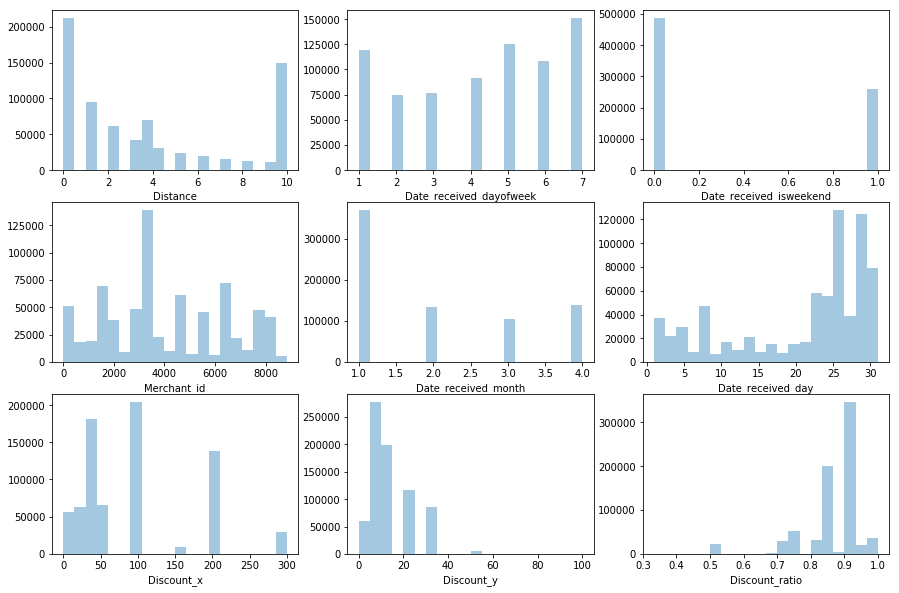

In [52]:
fig, ax = plt.subplots(4,3, figsize=(15,10))

sns.distplot(train['User_coupon_count'], kde=False, bins=20, ax =ax[0,0])
sns.distplot(train['Merchant_coupon_count'], kde=False, bins=20, ax =ax[0,1])

sns.distplot(train['Distance'], kde=False, bins=20, ax =ax[0,2])

sns.distplot(train['Date_received_dayofweek'], kde=False,bins=20, ax =ax[1,0])
sns.distplot(train['Date_received_isweekend'], kde=False,bins=20, ax =ax[1,1])
sns.distplot(train['Date_received_month'], kde=False,bins=20, ax =ax[1,2])

sns.distplot(train['Date_received_day'], kde=False,bins=20, ax =ax[2,0])

sns.distplot(train['Discount_type'], kde=False,bins=20, ax =ax[2,1])
sns.distplot(train['Discount_x'], kde=False, bins=20,ax =ax[2,2])

sns.distplot(train['Discount_y'], kde=False,bins=20, ax =ax[3,0])
sns.distplot(train['Discount_ratio'], kde=False,bins=20, ax =ax[3,1])
plt.show()

## Label transaction
 - couple w/o buy, label =0
 - buy w/ couple later than 15 days, label= 0
 - buy w/ couple in 15 days label= 1

In [16]:
def label_transaction(x):
    if pd.isna(x['Date']) or (x['Date']-x['Date_received'] > pd.Timedelta(15, 'D')):
        return 0
    elif x['Date'] - x['Date_received'] <= pd.Timedelta(15, 'D'):
        return 1
    else:
        return -1

train_labels = train.loc[:,["Date","Date_received"]].apply(label_transaction, axis =1)

In [ ]:
print(train.shape)
print("No use: {:%}".format(train_labels[train_labels==0].size/train.shape[0]))
print("Used: {:%}".format(train_labels[train_labels==1].size/train.shape[0]))

In [130]:
df = pd.concat([train, train_labels], axis=1)
corr_df = df.corr()
corr_df

,User_id,Merchant_id,Coupon_id,Distance,Date_received_dayofweek,Date_received_dayofweek_1,Date_received_dayofweek_2,Date_received_dayofweek_3,Date_received_dayofweek_4,Date_received_dayofweek_5,Date_received_dayofweek_6,Date_received_dayofweek_7,Date_received_month,Date_received_day,Date_received_isweekend,Discount_x,Discount_y,Discount_ratio,0
User_id,1.000000,0.001785,0.000235,-0.000573,-0.000449,-0.001140,-0.000882,0.002545,0.002540,0.000389,-0.003137,0.000089,-0.001256,0.001460,-0.002243,-0.000059,-0.001107,0.004100,-0.000653
Merchant_id,0.001785,1.000000,-0.061448,-0.004714,0.020994,0.046126,-0.025108,-0.054433,-0.016536,-0.038074,0.007861,0.059767,-0.067669,0.052364,0.056256,-0.105439,-0.103916,0.051490,0.020537
Coupon_id,0.000235,-0.061448,1.000000,0.023534,0.036216,-0.048727,-0.023041,-0.009699,0.034980,0.062607,-0.011682,-0.007715,-0.013172,-0.008372,-0.015145,-0.005068,0.039215,-0.076045,0.014643
Distance,-0.000573,-0.004714,0.023534,1.000000,-0.016831,0.064847,-0.017064,-0.023287,-0.035328,-0.025031,0.000462,0.022909,-0.181246,0.051885,0.019678,0.086334,0.146950,-0.029683,-0.152773
Date_received_dayofweek,-0.000449,0.020994,0.036216,-0.016831,1.000000,-0.680554,-0.361401,-0.205888,-0.050564,0.152999,0.335452,0.650272,-0.050782,0.129283,0.796779,0.037709,0.022939,0.015992,-0.016272
Date_received_dayofweek_1,-0.001140,0.046126,-0.048727,0.064847,-0.680554,1.000000,-0.145145,-0.147068,-0.163132,-0.196144,-0.179384,-0.219685,-0.069852,-0.057126,-0.318000,-0.061677,-0.055286,-0.002678,-0.013545
Date_received_dayofweek_2,-0.000882,-0.025108,-0.023041,-0.017064,-0.361401,-0.145145,1.000000,-0.112287,-0.124552,-0.149757,-0.136961,-0.167731,0.074184,-0.084359,-0.242795,-0.003626,0.011140,-0.004130,0.019470
Date_received_dayofweek_3,0.002545,-0.054433,-0.009699,-0.023287,-0.205888,-0.147068,-0.112287,1.000000,-0.126203,-0.151742,-0.138776,-0.169954,0.098295,-0.125391,-0.246013,-0.015605,-0.000418,-0.000346,0.021265
Date_received_dayofweek_4,0.002540,-0.016536,0.034980,-0.035328,-0.050564,-0.163132,-0.124552,-0.126203,1.000000,-0.168317,-0.153934,-0.188518,0.058884,-0.019624,-0.272884,0.057387,0.044468,0.024748,0.011912
Date_received_dayofweek_5,0.000389,-0.038074,0.062607,-0.025031,0.152999,-0.196144,-0.149757,-0.151742,-0.168317,1.000000,-0.185085,-0.226667,-0.036043,0.153996,-0.328107,0.016088,0.009596,-0.079342,-0.003852


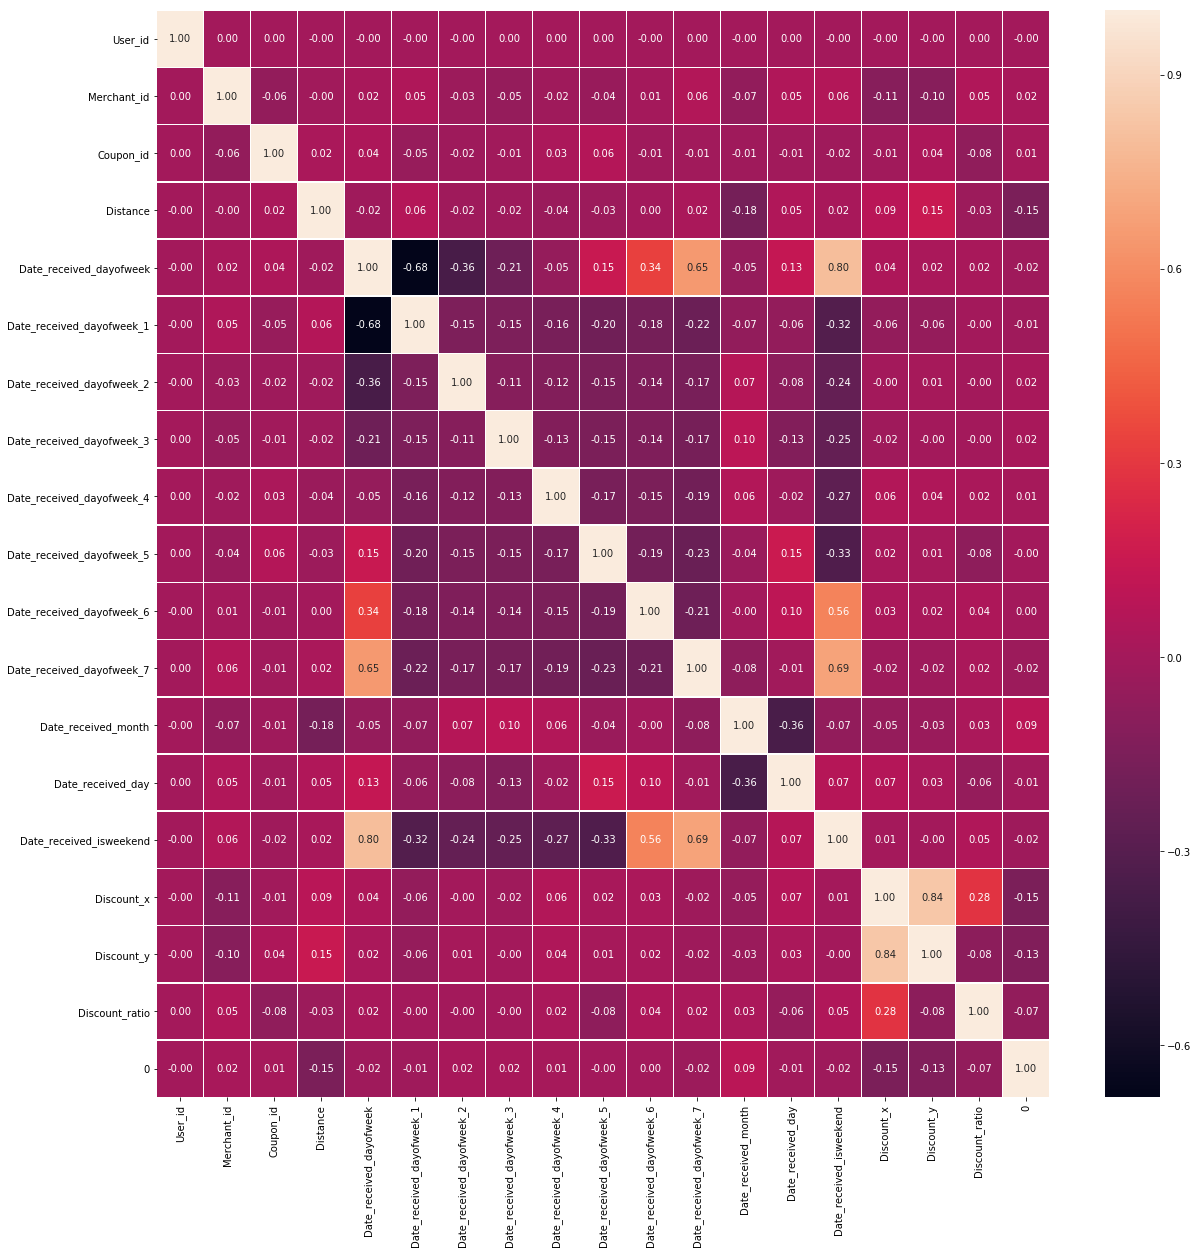

In [131]:
draw_heatmap(df, (20,20))

## Evalaute models 

In [101]:
features=["Merchant_id", "Distance","Date_received_dayofweek","Date_received_dayofweek_1","Date_received_dayofweek_2",
          "Date_received_dayofweek_3","Date_received_dayofweek_4","Date_received_dayofweek_5","Date_received_dayofweek_6",
          "Date_received_dayofweek_7","Date_received_isweekend","Date_received_month","Date_received_day","Discount_x", "Discount_y", "Discount_ratio"]
models = [DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
cross_evalaute(train[features], train_labels, models)

Best Accuracy: 0.9464611792677637 using DecisionTreeClassifier
Best Accuracy: 0.9479766309848294 using RandomForestClassifier
Best Accuracy: 0.9517732927070894 using GradientBoostingClassifier


## Select features

In [43]:
features=["Merchant_id", "Distance","Date_received_dayofweek","Date_received_dayofweek_1","Date_received_dayofweek_2",
          "Date_received_dayofweek_3","Date_received_dayofweek_4","Date_received_dayofweek_5","Date_received_dayofweek_6",
          "Date_received_dayofweek_7","Date_received_isweekend","Date_received_month","Date_received_day","Discount_x", "Discount_y", "Discount_ratio"]
models = [DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]

select_features(train[features], train_labels, models)

** Using DecisionTreeClassifier **
The number of selected features with cross-validation: 1
The mask of selected features: [ True False False False False False False False False False False False
 False False False False]
The selected features:Index(['Merchant_id'], dtype='object')
The feature ranking: [ 1  3  5 14 12 11 10  8 13 16 15  6  2  4  9  7]
** Using RandomForestClassifier **
The number of selected features with cross-validation: 1
The mask of selected features: [ True False False False False False False False False False False False
 False False False False]
The selected features:Index(['Merchant_id'], dtype='object')
The feature ranking: [ 1  2  5 14 11 15 10 12 13 16  9  6  3  4  7  8]
** Using GradientBoostingClassifier **
The number of selected features with cross-validation: 11
The mask of selected features: [ True  True  True False False False  True  True False  True False  True
  True  True  True  True]
The selected features:Index(['Merchant_id', 'Distance', 'Date_rec

## Search hyperparameters

In [42]:
features=["Merchant_id", "Distance","Date_received_dayofweek","Date_received_dayofweek_1","Date_received_dayofweek_2",
          "Date_received_dayofweek_3","Date_received_dayofweek_4","Date_received_dayofweek_5","Date_received_dayofweek_6",
          "Date_received_dayofweek_7","Date_received_isweekend","Date_received_month","Date_received_day","Discount_x", "Discount_y", "Discount_ratio"]

models = [DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]

param_grids=[{"max_depth":[4,8,12]},
             {"max_depth":[4,8,12], "n_estimators":[20,50,100]},
             {"n_estimators":[20, 50,100],"learning_rate":[0.01, 0.1, 0.5 ]}]


# for i in range(3):
#     search_params(train[features],train_labels, models[i], param_grids[i])


search_params(train[features],train_labels, models[2], param_grids[2])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 74.7min finished


** Using GradientBoostingClassifier **
Best Accuracy: 0.9514767254643661 using {'learning_rate': 0.1, 'n_estimators': 100}


## Read test data


In [17]:
DATA_ROOT = os.path.join(os.getcwd(), "data")
test_offline =  pd.read_csv(os.path.join(DATA_ROOT, "test_offline.csv"))

In [18]:
# test = test_offline.copy().iloc[:1000]
test = test_offline.copy()

# remove no coupon from test dataset
test = test[~test['Coupon_id'].isnull()]

# Convert Date_received as datetime dtype
test['Date_received'] = test['Date_received'].map(to_datetime)

#Add Date_received_weekday
test['Date_received_dayofweek'] = test['Date_received'].apply(lambda x: x.dayofweek+1)
oh_df = pd.get_dummies(test['Date_received_dayofweek'], 
                       prefix='Date_received_dayofweek')

test = pd.concat([test,oh_df], axis=1)
test['Date_received_month'] = test['Date_received'].apply(lambda x: x.month)
test['Date_received_day'] = test['Date_received'].apply(lambda x: x.day)


#Add Date_received_isweekend
test['Date_received_isweekend'] = test['Date_received'].map(to_isweekend)

# Add Discount_x and Discount_y
test['Discount_x'] = test['Discount_rate'].map(to_discount_x)
test['Discount_y'] = test['Discount_rate'].map(to_discount_y)
test['Discount_ratio'] = test['Discount_rate'].map(to_discount_ratio)

# Fill NA w/ 999 for Distance
test['Distance'] = test['Distance'].fillna(np.mean(test['Distance']))

test.head(10)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date_received_dayofweek,Date_received_dayofweek_1,Date_received_dayofweek_2,Date_received_dayofweek_3,Date_received_dayofweek_4,Date_received_dayofweek_5,Date_received_dayofweek_6,Date_received_dayofweek_7,Date_received_month,Date_received_day,Date_received_isweekend,Discount_x,Discount_y,Discount_ratio
0,1439408,4663,11002.0,150:20,1.000000,2016-05-28,6,0,0,0,0,0,1,0,5,28,1,150,20,0.866667
1,1439408,2632,8591.0,20:1,0.000000,2016-06-13,1,1,0,0,0,0,0,0,6,13,0,20,1,0.950000
3,1439408,2632,8591.0,20:1,0.000000,2016-05-16,1,1,0,0,0,0,0,0,5,16,0,20,1,0.950000
4,2029232,450,1532.0,30:5,0.000000,2016-05-30,1,1,0,0,0,0,0,0,5,30,0,30,5,0.833333
5,2029232,6459,12737.0,20:1,0.000000,2016-05-19,4,0,0,0,1,0,0,0,5,19,0,20,1,0.950000
8,2747744,6901,1097.0,50:10,1.949785,2016-06-06,1,1,0,0,0,0,0,0,6,6,0,50,10,0.800000
10,196342,1579,10698.0,20:1,1.000000,2016-06-06,1,1,0,0,0,0,0,0,6,6,0,20,1,0.950000
11,253750,6901,2366.0,30:5,0.000000,2016-05-18,3,0,0,1,0,0,0,0,5,18,0,30,5,0.833333
12,343660,4663,11002.0,150:20,1.949785,2016-05-28,6,0,0,0,0,0,1,0,5,28,1,150,20,0.866667
15,1113008,3621,2705.0,20:5,0.000000,2016-05-24,2,0,1,0,0,0,0,0,5,24,0,20,5,0.750000


In [134]:
test.describe()

,User_id,Merchant_id,Coupon_id,Distance,Date_received_dayofweek,Date_received_dayofweek_1,Date_received_dayofweek_2,Date_received_dayofweek_3,Date_received_dayofweek_4,Date_received_dayofweek_5,Date_received_dayofweek_6,Date_received_dayofweek_7,Date_received_month,Date_received_day,Date_received_isweekend,Discount_x,Discount_y,Discount_ratio
count,3.063130e+05,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000,306313.000000
mean,3.681999e+06,3640.616419,6145.500612,1.949785,4.050197,0.139566,0.131473,0.151639,0.133997,0.138241,0.170009,0.135074,5.296967,15.931341,0.305083,46.237558,7.520334,0.832283
std,2.122008e+06,2589.367153,4135.385856,2.892470,1.991248,0.346537,0.337918,0.358671,0.340650,0.345153,0.375641,0.341803,0.456923,8.635558,0.460443,44.541600,8.014316,0.100168
min,4.000000e+00,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.333333
25%,1.842402e+06,1080.000000,2418.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,8.000000,0.000000,20.000000,5.000000,0.750000
50%,3.684421e+06,3585.000000,4958.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,17.000000,0.000000,30.000000,5.000000,0.833333
75%,5.518531e+06,5800.000000,9746.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,23.000000,1.000000,50.000000,10.000000,0.900000
max,7.360961e+06,8856.000000,14045.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,31.000000,1.000000,300.000000,100.000000,1.000000


## Prediction and submission

In [38]:
def to_submit(data, target, model, atest, submit):    
    model.fit(data, target)
    predict_test = model.predict_proba(atest) 
    submit['label'] = predict_test[:,1]
    submit = submit.groupby("uid", as_index=False).mean()
    fname = "submission_"+ model.__class__.__name__+".csv"
    submit.to_csv(os.path.join(DATA_ROOT, fname), header=True, index=False)

In [39]:
# prepare the submission
user_id = test["User_id"].astype('str')
coupon_id = test["Coupon_id"].map(lambda x: str(int(x)))
date_received = test["Date_received"].map(lambda x: x.strftime('%Y%m%d')) 
submit = pd.DataFrame()
submit["uid"] = user_id+"_"+coupon_id + "_" +date_received

## Prediction practices

In [145]:
# all features, selected params
features=["Merchant_id", "Distance","Date_received_dayofweek","Date_received_dayofweek_1","Date_received_dayofweek_2",
          "Date_received_dayofweek_3","Date_received_dayofweek_4","Date_received_dayofweek_5","Date_received_dayofweek_6",
          "Date_received_dayofweek_7","Date_received_isweekend","Date_received_month","Date_received_day","Discount_x", "Discount_y", "Discount_ratio"]

models = [DecisionTreeClassifier(max_depth=8), RandomForestClassifier(max_depth=12, n_estimators=100), 
          GradientBoostingClassifier(learning_rate=0.5, n_estimators=20)]

for i in range(3):
    to_submit(train[features], train_labels, models[i], test[features], submit)

In [92]:
# selected features, selected params
featureset=[["Merchant_id", "Distance","Date_received_dayofweek", "Discount_x"], 
            ["Merchant_id", "Distance","Date_received_dayofweek", "Discount_x", "Discount_y"],
            ['Merchant_id', 'Distance', 'Date_received_dayofweek', 'Discount_x','Discount_y','Discount_ratio']]

models=[ DecisionTreeClassifier(max_depth=8), 
        RandomForestClassifier(max_depth=12, n_estimators=100), 
        GradientBoostingClassifier(learning_rate=0.5, n_estimators=20) ]

for i in range(3):
    to_submit(train[featureset[i]], train_labels, models[i], test[featureset[i]], submit)

In [72]:
# voting
# selected features, selected params
featureset=[["Merchant_id", "Distance","Date_received_dayofweek", "Discount_x"], 
            ["Merchant_id", "Distance","Date_received_dayofweek", "Discount_x", "Discount_y"],
            ['Merchant_id', 'Distance', 'Date_received_dayofweek', 'Discount_x','Discount_y','Discount_ratio'],
            ['Distance', 'Date_received_dayofweek', 'Discount_x'],
            ['Discount_x','Discount_y','Discount_ratio']]

models = {"dt":DecisionTreeClassifier(max_depth=8), 
          "rf":RandomForestClassifier(max_depth=12, n_estimators=100), 
          "gb":GradientBoostingClassifier(learning_rate=0.5, n_estimators=20)}
            
            
volting = VotingClassifier(estimators=models.items(), voting='soft', weights=[2, 1, 2])
to_submit(train[featureset[4]], train_labels, volting, test[featureset[4]], submit)

In [160]:
#stacking
# all features, selected params
from mlxtend.classifier import StackingCVClassifier

features=["Merchant_id", "Distance","Date_received_dayofweek","Date_received_dayofweek_1","Date_received_dayofweek_2",
          "Date_received_dayofweek_3","Date_received_dayofweek_4","Date_received_dayofweek_5","Date_received_dayofweek_6",
          "Date_received_dayofweek_7","Date_received_isweekend","Date_received_month","Date_received_day","Discount_x", "Discount_y", "Discount_ratio"]

models = [DecisionTreeClassifier(max_depth=8), RandomForestClassifier(max_depth=12, n_estimators=100), 
          GradientBoostingClassifier(learning_rate=0.1, n_estimators=20)]


stacking = StackingCVClassifier(classifiers=models, meta_classifier=LogisticRegression(), random_state=42, use_probas=True)                                                  
to_submit(train[features], train_labels, stacking, test[features], submit)                                          

In [37]:
#GradientBoostingClassifier w left encoding
features=["Merchant_id", "Distance","Date_received_dayofweek","Date_received_dayofweek_1","Date_received_dayofweek_2",
          "Date_received_dayofweek_3","Date_received_dayofweek_4","Date_received_dayofweek_5","Date_received_dayofweek_6",
          "Date_received_dayofweek_7","Date_received_isweekend","Date_received_month","Date_received_day","Discount_x", "Discount_y", "Discount_ratio"]

train_X, test_X, train_y, test_y = train_test_split(train[features], train_labels, test_size=0.3)
train_X, val_X, train_Y, val_Y = train_test_split(train[features], train_labels, test_size=0.3)

gdbt = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20)
gdbt.fit(train_X, train_Y)
onehot = OneHotEncoder()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

onehot.fit(gdbt.apply(train_X)[:, :, 0])
lr.fit(onehot.transform(gdbt.apply(val_X)[:, :, 0]), val_Y)
pred_gdbt_lr = lr.predict_proba(onehot.transform(gdbt.apply(test[features])[:, :, 0]))[:, 1]

submit['label'] = pred_gdbt_lr
submit = submit.groupby("uid", as_index=False).mean()
fname = "submission_"+ gdbt.__class__.__name__+".csv"
submit.to_csv(os.path.join(DATA_ROOT, fname), header=True, index=False)

array([0.07275967, 0.12380635, 0.12380635, ..., 0.06541436, 0.01575625,
       0.12022174])